# **Tendencias Salariales en Empleos de Ciencia de Datos, AI y ML (2025)**

**Autores:** Laura Cardona Ahumada, Elian Martinez Orozco, Evelyn Mondul y Luis Pino Perez

**Fecha:** agosto 2025

---

### **Introducción**

Esta base de datos presenta información actualizada sobre salarios globales en 2025 para profesionales de Ciencia de Datos, Aprendizaje Automático e Inteligencia Artificial. Fue construida a partir de fuentes públicas como AIJobs, 365DataScience, Payscale, KDnuggets y ZipRecruiter, y está orientada a apoyar análisis de mercado, modelos predictivos, visualizaciones interactivas y estudios sobre trabajo remoto.

El conjunto de datos fue obtenido desde Kaggle, a partir del recurso publicado por el usuario adilshamim8 bajo el título "Salaries for Data Science Jobs": https://www.kaggle.com/datasets/adilshamim8/salaries-for-data-science-jobs?resource=download. Su contenido resulta útil para investigadores, profesionales del sector, estudiantes y reclutadores que buscan entender las dinámicas actuales de compensación en el ámbito tecnológico.

---

### **Objetivo**

El presente análisis tiene como objetivo desarrollar un modelo de aprendizaje automático capaz de predecir el rango salarial de empleos relacionados con Ciencia de Datos, Inteligencia Artificial y Aprendizaje Automático, a partir de información sobre características laborales y profesionales.  
Además, se realizará un análisis exploratorio detallado de los datos para identificar patrones, desigualdades y factores determinantes del salario en estas áreas tecnológicas emergentes.

---

En este notebook se encuentran las siguientes sesiones: 
1. Importaciones y configuración inicial
2. Carga de datos y selección de columnas
3. Análisis exploratorio de datos - EDA
4. Split Train / Validation / Test
5. Preprocesamiento
6. Modelos y búsqueda de hiperparámetros
7. Funciones auxiliares
8. Loop para evaluar modelos + gráficas + BDS
9. DataFrame de resultados y gráfico comparativo


## 1. Importaciones y configuración inicial
Aquí cargamos todas las librerías necesarias:
1. Sklearn → para modelos, pipelines, métricas y validación cruzada.
2. XGBoost y MLP → modelos más avanzados.
3. statsmodels.tsa.stattools → para el BDS test en los residuos.
4. Matplotlib / PrettyTable → para gráficos y tablas estructuradas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from statsmodels.tsa.stattools import bds
from prettytable import PrettyTable

## 2. Carga de datos y selección de columnas

1. Leemos el archivo salaries.csv.
2. Definimos variables categóricas (ejemplo: job_title, company_size) y numéricas (ejemplo: salario, work_year).
3. Construimos X_full (features) y y_full_price (target → salary_in_usd).

Aquí limpiamos y organizamos el dataset.

In [2]:
DATA_PATH = r"C:\Users\LUIS PINO\Documents\Machine_learning\Proyecto_final\salaries.csv"
defg= pd.read_csv(DATA_PATH)

df = defg[defg['work_year'] == 2025]

categorical_features = ['experience_level','employment_type','job_title','salary_currency','employee_residence','company_location','company_size']
numeric_features = ['salary','salary_in_usd','remote_ratio']

categorical_features = [c for c in categorical_features if c in df.columns]
numeric_features = [c for c in numeric_features if c in df.columns]

X_full = df[categorical_features + numeric_features].copy()
y_full_price = df['salary_in_usd'].copy()

## 3. Análisis exploratorio de datos - EDA

In [3]:
sns.set(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 6)

# Mostrar las primeras filas
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EX,FT,Head of Data,348516,USD,348516,US,0,US,M
1,2025,EX,FT,Head of Data,232344,USD,232344,US,0,US,M
2,2025,SE,FT,Data Scientist,145400,USD,145400,US,0,US,M
3,2025,SE,FT,Data Scientist,81600,USD,81600,US,0,US,M
4,2025,MI,FT,Engineer,160000,USD,160000,US,100,US,M


#### **Dataset**

In [4]:
# Dimensiones
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

# Tipos de datos
print(df.dtypes)

# Información general
print(df.info())

# Estadísticas descriptivas
print(df.describe(include='all'))

# duplicadas
print("\nFilas duplicadas:", df.duplicated().sum())

Filas: 78726, Columnas: 11
work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 78726 entries, 0 to 78850
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           78726 non-null  int64 
 1   experience_level    78726 non-null  object
 2   employment_type     78726 non-null  object
 3   job_title           78726 non-null  object
 4   salary              78726 non-null  int64 
 5   salary_currency     78726 non-null  object
 6   salary_in_usd       78726 non-null  int64 
 7   employee_residence  78726 non-null  object
 8   remote_ratio        78726 non-null  int64 
 9   com

### **Variables**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78726 entries, 0 to 78850
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           78726 non-null  int64 
 1   experience_level    78726 non-null  object
 2   employment_type     78726 non-null  object
 3   job_title           78726 non-null  object
 4   salary              78726 non-null  int64 
 5   salary_currency     78726 non-null  object
 6   salary_in_usd       78726 non-null  int64 
 7   employee_residence  78726 non-null  object
 8   remote_ratio        78726 non-null  int64 
 9   company_location    78726 non-null  object
 10  company_size        78726 non-null  object
dtypes: int64(4), object(7)
memory usage: 7.2+ MB


In [6]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,78726.0,7.872600e+04,78726.000000,78726.000000
mean,2025.0,1.629982e+05,157018.982585,20.316033
std,0.0,2.206844e+05,75599.012724,40.219553
min,2025.0,1.440000e+04,15157.000000,0.000000
25%,2025.0,1.050000e+05,104885.250000,0.000000
50%,2025.0,1.460000e+05,145100.000000,0.000000
75%,2025.0,1.975000e+05,197000.000000,0.000000
max,2025.0,3.000000e+07,800000.000000,100.000000


 El 93% de los datos corresponden a 2024–2025. Los salarios típicos en USD se ubican entre 105,000 y 198,000, aunque existen outliers muy altos (hasta 800,000). La mitad de los empleos son presenciales, con una proporción menor en teletrabajo total.

#### Distribución de variables numéricas

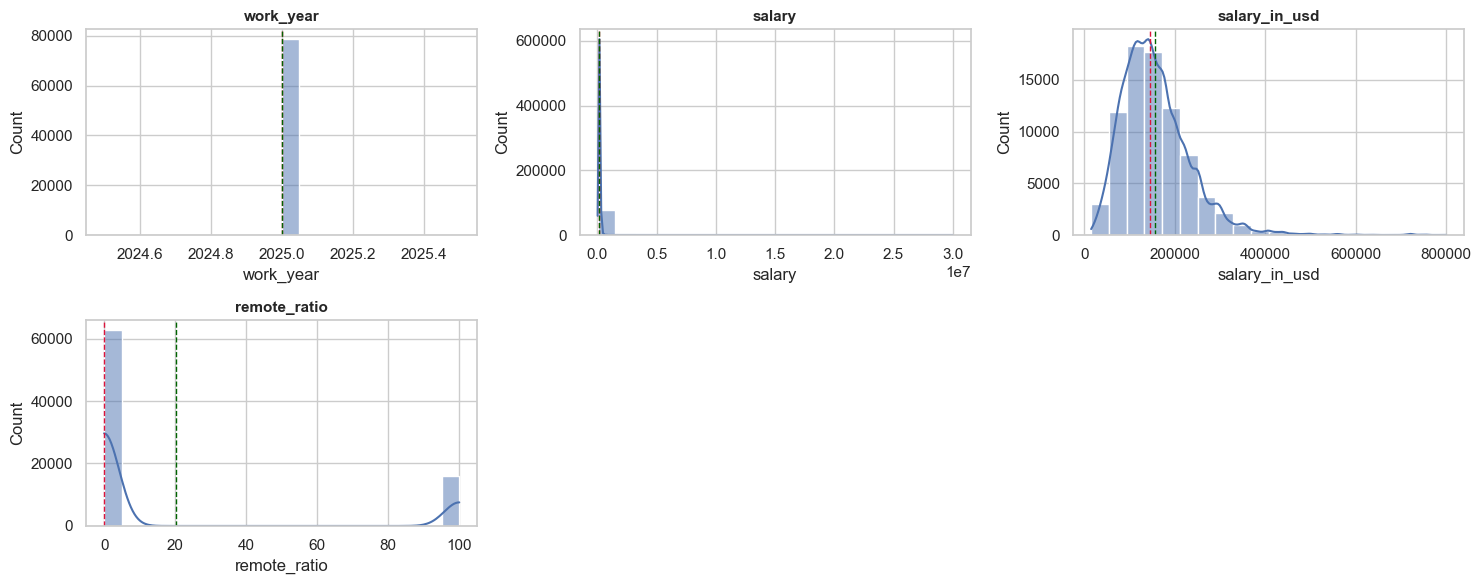

In [7]:
sns.set(style="whitegrid")

numerical_cols = df.select_dtypes(include=np.number).columns
n = len(numerical_cols)

# Calcular filas y columnas automáticamente
cols = 3
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, bins=20, color='#4C72B0', ax=axes[i])
    axes[i].axvline(df[col].median(), color='crimson', linestyle='--', linewidth=1)
    axes[i].axvline(df[col].mean(), color='darkgreen', linestyle='--', linewidth=1)
    axes[i].set_title(f"{col}", fontsize=11, fontweight="bold")

# Eliminar ejes vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Distribución de variables categóricas

C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_39504\2877972932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_39504\2877972932.py:12: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_39504\2877972932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_39504\2877972932.py:12: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.countplot(
C:\Users\LUIS PINO\AppData\Local\Temp\ipykernel_39504\2877972932.py:12

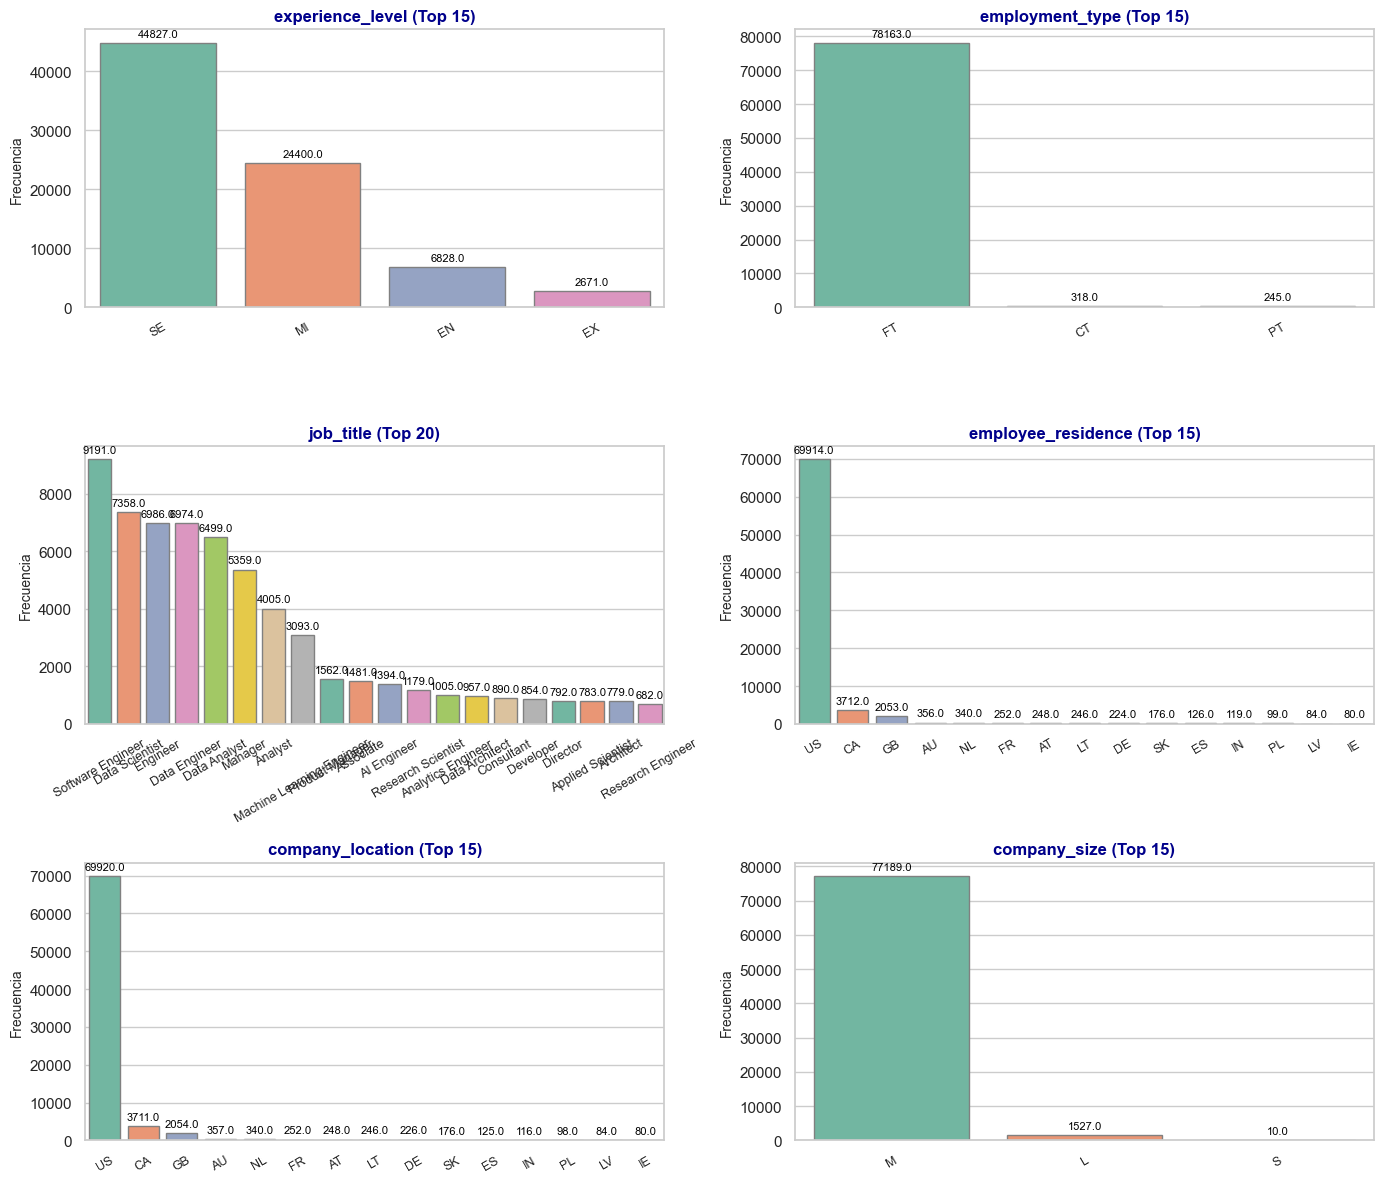

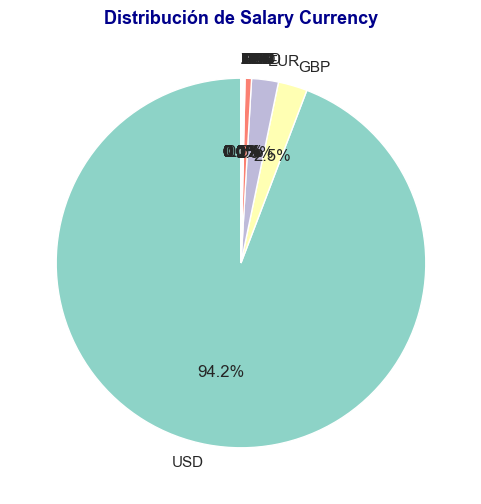

In [8]:
sns.set_style("whitegrid")
palette_cat = sns.color_palette("Set2")

# Función auxiliar: Top N
def plot_top_categories(df, col, top_n=15, ax=None):
    """
    Grafica un countplot con las Top N categorías más frecuentes.
    """
    top_values = df[col].value_counts().nlargest(top_n).index
    data = df[df[col].isin(top_values)]

    ax = sns.countplot(
        data=data,
        x=col,
        order=data[col].value_counts().index,
        palette=palette_cat,
        edgecolor='gray',
        ax=ax
    )

    ax.set_title(f'{col} (Top {top_n})', fontsize=12, fontweight='bold', color='darkblue')
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia", fontsize=10)
    ax.tick_params(axis='x', rotation=30, labelsize=9)

    # Etiquetas en las barras
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height}', 
                        (bar.get_x() + bar.get_width()/2, height),
                        ha='center', va='bottom', fontsize=8,
                        color='black', xytext=(0, 3),
                        textcoords='offset points')

    return ax


# Gráficas categóricas
categorical_cols = df.select_dtypes(include='object').columns

# Ajustes para columnas específicas
special_top = {
    "job_title": 20,            
    "employee_residence": 15,   
    "company_location": 15      
}

# Excluir salary_currency (lo graficamos como pastel)
categorical_cols = [c for c in categorical_cols if c != "salary_currency"]

n = len(categorical_cols)
cols = 2
rows = (n // cols) + (n % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    top_n = special_top.get(col, 15)  # por defecto Top 15
    plot_top_categories(df, col, top_n=top_n, ax=axes[i])

# Eliminar ejes sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Gráfico de Salary Currency

currency_counts = df["salary_currency"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(currency_counts.values, labels=currency_counts.index,
        autopct='%1.1f%%', colors=sns.color_palette("Set3"), startangle=90)
plt.title("Distribución de Salary Currency", fontsize=13, fontweight="bold", color="darkblue")
plt.show()

### Tasa anual de contratación de profesionales en ciencia de datos

In [9]:
df['work_year'].value_counts()

work_year
2025    78726
Name: count, dtype: int64

#### Impacto del nivel de experiencia en las oportunidades de empleo cada año

In [10]:
df.groupby('work_year')['experience_level'].value_counts()

work_year  experience_level
2025       SE                  44827
           MI                  24400
           EN                   6828
           EX                   2671
Name: count, dtype: int64

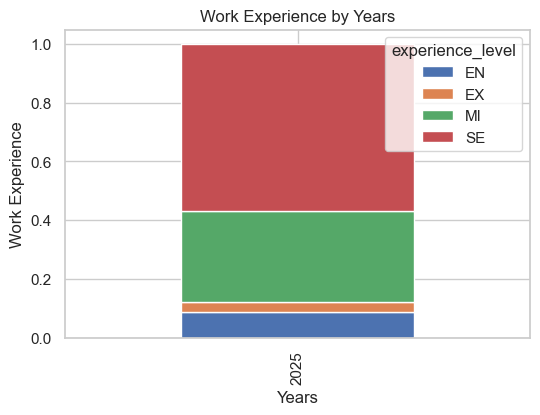

In [11]:
df_counts = df.groupby('work_year')['experience_level'].value_counts().unstack(fill_value=0)
df_props = df_counts.div(df_counts.sum(axis=1), axis=0)

df_props.plot(kind='bar', stacked=True, figsize=(6,4))
plt.xlabel('Years')
plt.ylabel('Work Experience')
plt.title('Work Experience by Years')
plt.show()

Se puede evidenciar que el mercado de Ciencia de Datos favorece perfiles Senior y Mid-level, pero sigue abriendo espacio para entry-level, aunque en menor medida.

#### Cambio de salarios a lo largo del tiemp

In [12]:
df.groupby('work_year')['salary_in_usd'].mean()

work_year
2025    157018.982585
Name: salary_in_usd, dtype: float64

Después de una ligera caída en 2021, los salarios han mostrado una tendencia creciente hasta 2024, con una leve disminución en 2025.

#### Distribución salarial según el nivel de experiencia

In [13]:
df.groupby('experience_level')['salary_in_usd'].mean()

experience_level
EN     96141.221002
EX    201188.182329
MI    141753.112295
SE    171969.451246
Name: salary_in_usd, dtype: float64

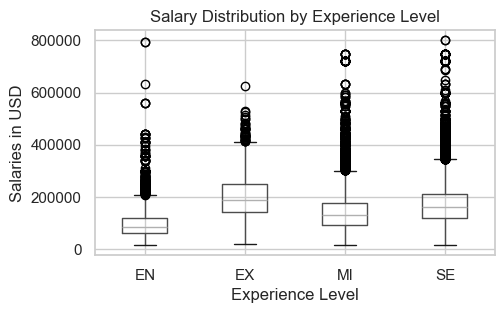

In [14]:
df.boxplot(column='salary_in_usd', by='experience_level', figsize=(5,3))
plt.title('Salary Distribution by Experience Level')
plt.suptitle('')
plt.xlabel('Experience Level')
plt.ylabel('Salaries in USD')
plt.show()

Los resultados muestran que el nivel de experiencia tiene un impacto claro en los salarios promedio.

#### Salarios según el tipo de empleo

In [15]:
df.groupby('employment_type')['salary_in_usd'].mean()

employment_type
CT    102683.996855
FT    157494.825736
PT     75734.073469
Name: salary_in_usd, dtype: float64

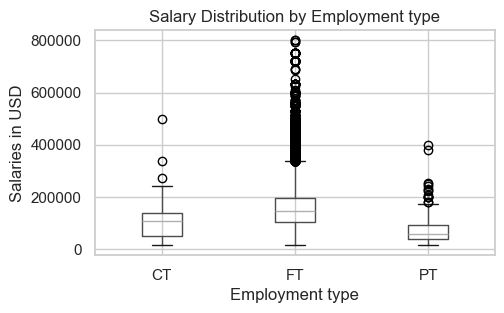

In [16]:
df.boxplot(column='salary_in_usd', by='employment_type', figsize=(5,3))
plt.title('Salary Distribution by Employment type')
plt.suptitle('')
plt.xlabel('Employment type')
plt.ylabel('Salaries in USD')
plt.show()

Se puede observar que los profesionales a tiempo completo son quienes reciben los salarios más altos en promedio, mientras que los freelancers y los de medio tiempo ganan bastante menos.

#### Títulos de trabajo con los salarios promedios más altos

In [17]:
df.groupby('job_title')['salary_in_usd'].median().sort_values(ascending = False).head(7)

job_title
Research Team Lead                450000.0
IT Enterprise Data Architect      284090.0
Head of Applied AI                281500.0
AIRS Solutions Specialist         263250.0
Director of Product Management    260000.0
Commercial Counsel                250000.0
Head of Machine Learning          250000.0
Name: salary_in_usd, dtype: float64

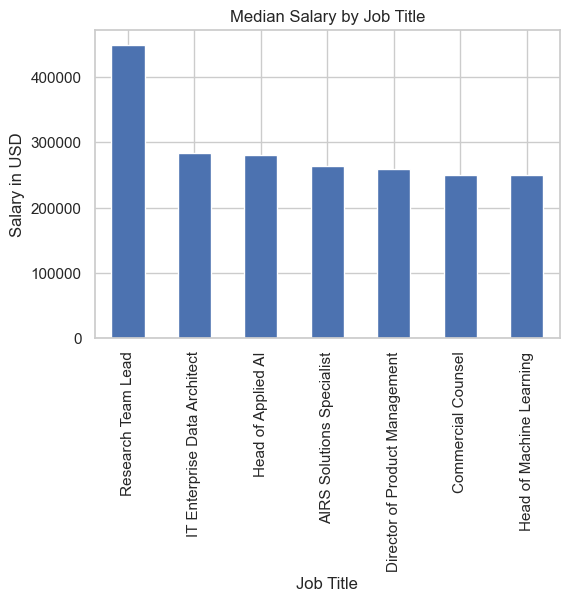

In [18]:
df.groupby('job_title')['salary_in_usd'].median().sort_values(ascending=False).head(7).plot.bar(figsize=(6,4))
plt.xlabel('Job Title')
plt.ylabel('Salary in USD')
plt.title('Median Salary by Job Title')
plt.show()

Nos confirma que los puestos de liderazgo y gestión en ciencia de datos, analítica e inteligencia artificial son los que concentran los salarios más altos.

### Los títulos de trabajo más comunes

In [19]:
df['job_title'].value_counts().head(7)

job_title
Software Engineer    9191
Data Scientist       7358
Engineer             6986
Data Engineer        6974
Data Analyst         6499
Manager              5359
Analyst              4005
Name: count, dtype: int64

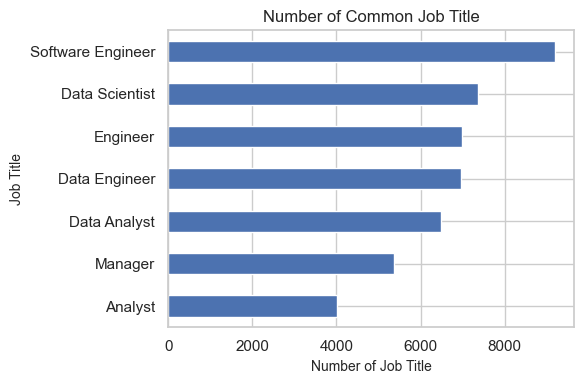

In [20]:
plt.figure(figsize=(6,4))
df['job_title'].value_counts().head(7).sort_values().plot.barh()
plt.ylabel('Job Title', fontsize=10)
plt.xlabel('Number of Job Title', fontsize=10)
plt.title('Number of Common Job Title', fontsize=12)
plt.tight_layout()
plt.show()

Los roles más comunes están relacionados con ciencia de datos, ingeniería de software y análisis de datos, siendo Data Scientist el más frecuente

### Impacto del trabajo remoto en el salario

In [21]:
df.groupby('remote_ratio')['salary_in_usd'].mean()

remote_ratio
0      157946.549512
50      80514.675000
100    153569.038625
Name: salary_in_usd, dtype: float64

In [22]:
remote_salary = df.groupby('remote_ratio')['salary_in_usd'].mean()
remote_salary = remote_salary.rename({
    0: 'On-site',
    50: 'Hybrid',
    100: 'Fully Remote'
})
print(remote_salary)

remote_ratio
On-site         157946.549512
Hybrid           80514.675000
Fully Remote    153569.038625
Name: salary_in_usd, dtype: float64


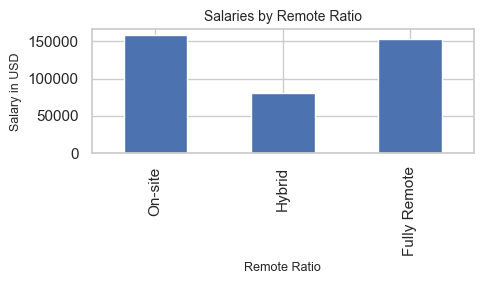

In [23]:
plt.figure(figsize=(5,3))
remote_salary.plot.bar()
plt.xlabel('Remote Ratio', fontsize=9)
plt.ylabel('Salary in USD', fontsize=9)
plt.title('Salaries by Remote Ratio', fontsize=10)
plt.tight_layout()
plt.show()

los trabajos totalmente presenciales (On-site) y completamente remotos (Fully Remote) tienen salarios promedio más altos, mientras que los puestos híbridos (Hybrid) presentan un salario promedio significativamente menor.

### Influencia del tamaño de la empresa en el salario

In [24]:
df.groupby('company_size')['salary_in_usd'].mean()

company_size
L    168145.897184
M    156807.909858
S     87188.400000
Name: salary_in_usd, dtype: float64

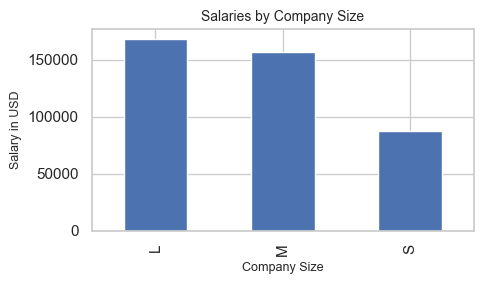

In [25]:
plt.figure(figsize=(5,3))
df.groupby('company_size')['salary_in_usd'].mean().plot.bar()
plt.xlabel('Company Size', fontsize=9)
plt.ylabel('Salary in USD', fontsize=9)
plt.title('Salaries by Company Size', fontsize=10)
plt.tight_layout()
plt.show()

Se observa que las empresas grandes (L) y medianas (M) ofrecen salarios promedio significativamente más altos que las pequeñas (S).

### Relación entre el tamaño de la empresa y la contratación de empleados remotos

In [26]:
df.groupby('company_size')['remote_ratio'].value_counts()

company_size  remote_ratio
L             0                1443
              100                53
              50                 31
M             0               61266
              100             15916
              50                  7
S             100                 5
              0                   3
              50                  2
Name: count, dtype: int64

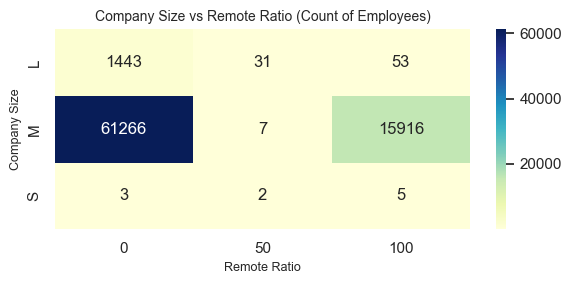

In [27]:
plt.figure(figsize=(6,3))
counts = df.groupby('company_size')['remote_ratio'].value_counts().unstack(fill_value=0)
sns.heatmap(counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Company Size vs Remote Ratio (Count of Employees)', fontsize=10)
plt.ylabel('Company Size', fontsize=9)
plt.xlabel('Remote Ratio', fontsize=9)
plt.tight_layout()
plt.show()

Las empresas más grandes tienden a tener más empleados presenciales, mientras que las pequeñas muestran una proporción relativamente mayor de trabajadores totalmente remotos.

#### Matriz de correlación

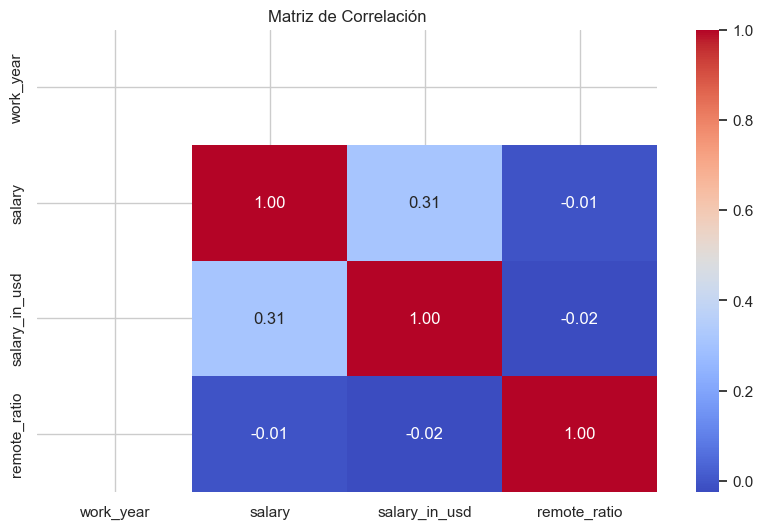

In [28]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

La matriz de correlación muestra que salary y salary_in_usd están moderadamente relacionadas, mientras que remote_ratio y work_year presentan correlaciones bajas con las demás variables, lo que sugiere que no hay evidencia clara de que la modalidad de trabajo remoto o el año del registro influyan en el salario.

## 4. Split Train / Test

Separamos el dataset en 3 subconjuntos:

1. Train (80%) → usado para entrenar los modelos.
2. Test (20%) → para evaluar el rendimiento final de los modelos.

Esto evita sobreajuste y asegura una prueba justa al final.

In [29]:
# 80% Train, 20% Test
y_full_price = np.log1p(df['salary_in_usd'])
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_full, y_full_price, test_size=0.2, random_state=42
)

## 5. Preprocesamiento

Definimos un pipeline de transformación:

1. Categóricas → imputar valores faltantes + OneHotEncoding.
2. Numéricas → imputar valores faltantes + escalado.
3. 3 ColumnTransformer.

Así garantizamos que todos los modelos reciban datos ya limpios y escalados.

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numeric_transformer_standard = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor_standard = ColumnTransformer([
    ("cat", categorical_transformer, categorical_features),
    ("num", numeric_transformer_standard, numeric_features)
])

## 6. Modelos y búsqueda de hiperparámetros

Definimos 7 modelos: Ridge, Lasso, KNN, Árbol, SVR, XGBoost, MLP.

1. Configuramos sus hiperparámetros candidatos.
2. Usamos GridSearchCV (para búsquedas exhaustivas) y RandomizedSearchCV (para búsqueda aleatoria en rangos amplios).
3. Cada búsqueda usa validación cruzada (cv=3) dentro del conjunto de entrenamiento.

Aquí encontramos la “mejor versión” de cada modelo.

In [32]:
ridge = Pipeline(steps=[("preprocessor", preprocessor_standard), ("model", Ridge())])
lasso = Pipeline(steps=[("preprocessor", preprocessor_standard), ("model", Lasso())])
knn = Pipeline(steps=[("preprocessor", preprocessor_standard), ("model", KNeighborsRegressor())])
dtree = Pipeline(steps=[("preprocessor", preprocessor_standard), ("model", DecisionTreeRegressor(random_state=42))])
svr = Pipeline(steps=[("preprocessor", preprocessor_standard), ("model", SVR())])
xgb = Pipeline(steps=[("preprocessor", preprocessor_standard), ("model", XGBRegressor(objective="reg:squarederror", random_state=42))])
mlp = Pipeline(steps=[("preprocessor", preprocessor_standard), ("model", MLPRegressor(max_iter=500, random_state=42, early_stopping=True))])

ridge_params = {"model__alpha": [0.01, 0.1, 1, 10]}
lasso_params = {"model__alpha": [0.01, 0.1, 1, 10]}
knn_params = {"model__n_neighbors": [3, 5, 7, 9]}
dtree_params = {"model__max_depth": [3, 5, 7, 10], "model__min_samples_leaf": [5, 10, 20], "model__max_features": ["sqrt", "log2"]}
svr_params = {"model__C": [0.1, 1, 10], "model__kernel": ["rbf", "linear"]}
xgb_params = {"model__n_estimators": randint(100, 500), "model__max_depth": randint(3, 6), "model__learning_rate": uniform(0.01, 0.2)}
mlp_params = {"model__hidden_layer_sizes": [(50,), (100,), (50,50)], "model__alpha": uniform(0.0001, 0.01),"model__activation": ["relu", "tanh"]}

ridge_search = GridSearchCV(ridge, ridge_params, cv=3, scoring="neg_mean_squared_error")
lasso_search = GridSearchCV(lasso, lasso_params, cv=3, scoring="neg_mean_squared_error")
knn_search = GridSearchCV(knn, knn_params, cv=3, scoring="neg_mean_squared_error")
dtree_search = GridSearchCV(dtree, dtree_params, cv=3, scoring="neg_mean_squared_error")
svr_search = GridSearchCV(svr, svr_params, cv=3, scoring="neg_mean_squared_error")
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=30, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1, verbose=1)
mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=30, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1)

for search in [ridge_search, lasso_search, knn_search, dtree_search, svr_search, xgb_search, mlp_search]:
    search.fit(X_train_reg, y_train_reg)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


## 7. Funciones auxiliares

1. Evaluate_model → calcula métricas (MAE, MSE, RMSE, MAPE) para Train/Val/Test.

Son funciones de apoyo para evitar repetir código.

In [ ]:

def regression_metrics(y_true, y_pred):
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)
    mae = mean_absolute_error(y_true_exp, y_pred_exp)
    mse = mean_squared_error(y_true_exp, y_pred_exp)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true_exp - y_pred_exp) / y_true_exp)) * 100
    return mae, mse, rmse, mape

## 8. Loop para evaluar modelos + gráficas + BDS - resultados en Log

1. Iteramos por cada modelo entrenado.
2. Guardamos sus métricas en Train/Test.
3. Aplicamos el BDS Test en el conjunto de Test (para independencia de residuos).
4. Generamos gráficos comparativos (Real vs Predicho) en cada conjunto.

Aquí ocurre la evaluación central.

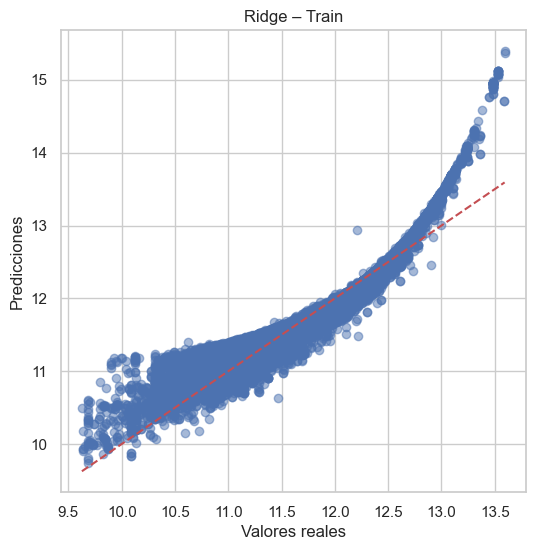

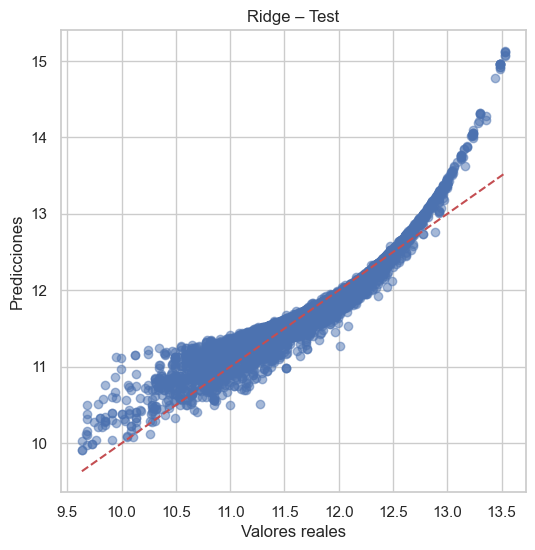

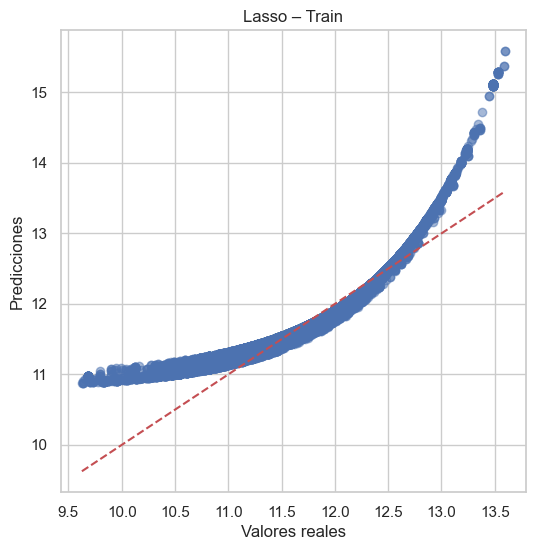

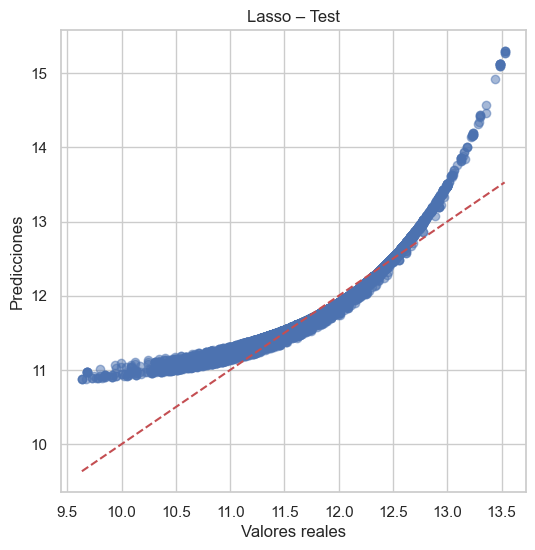

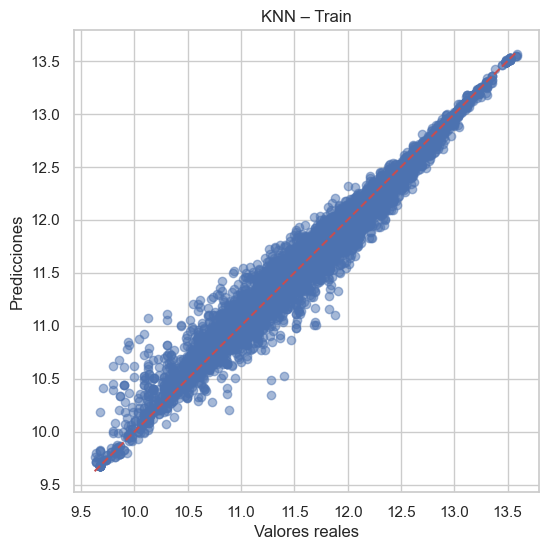

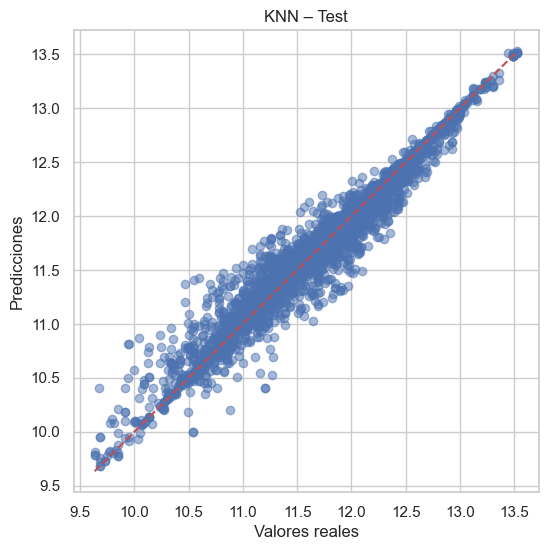

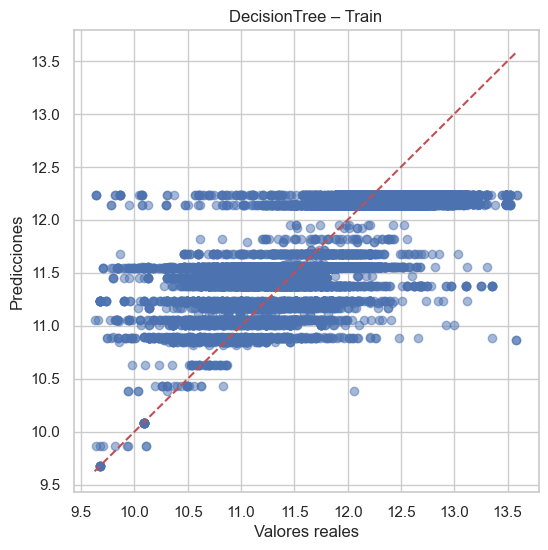

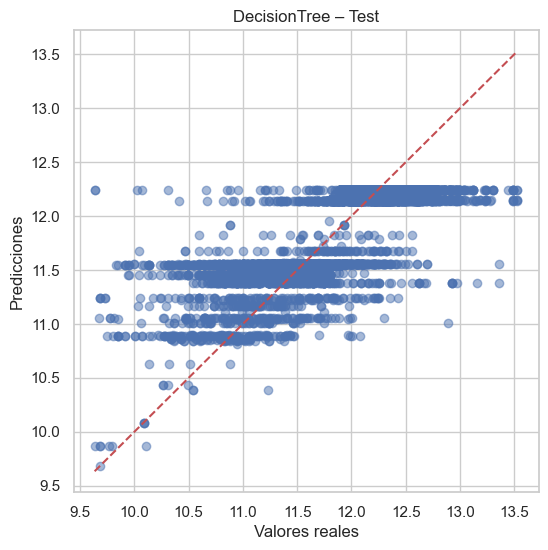

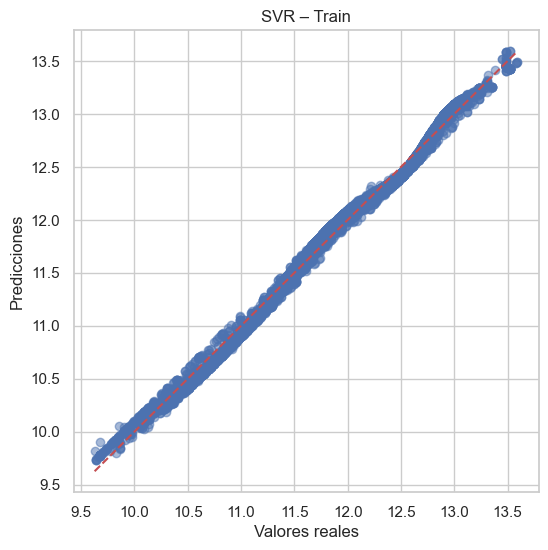

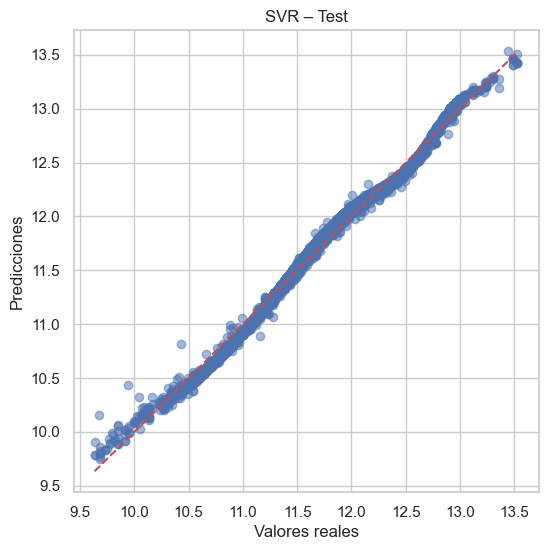

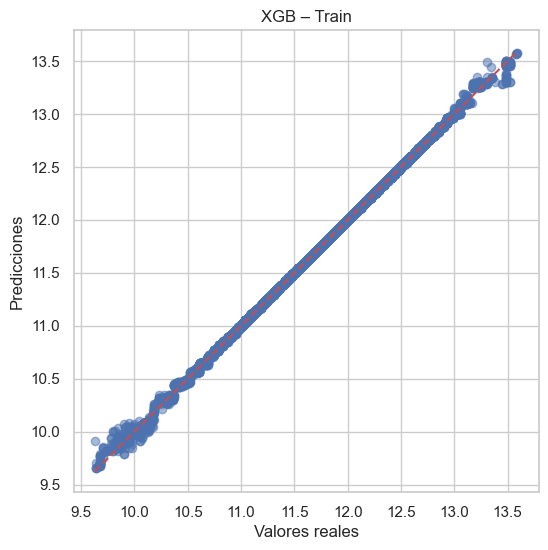

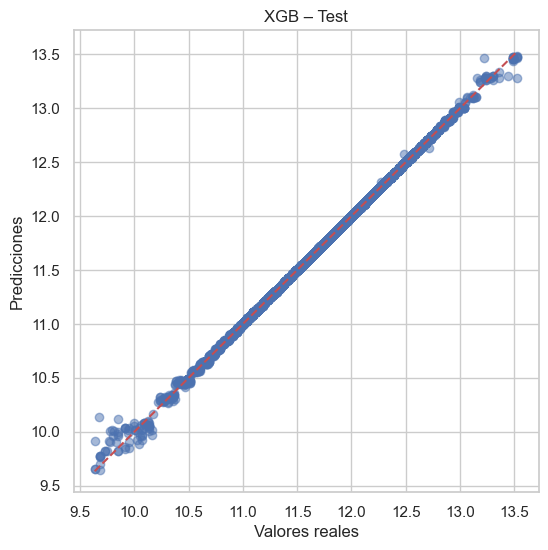

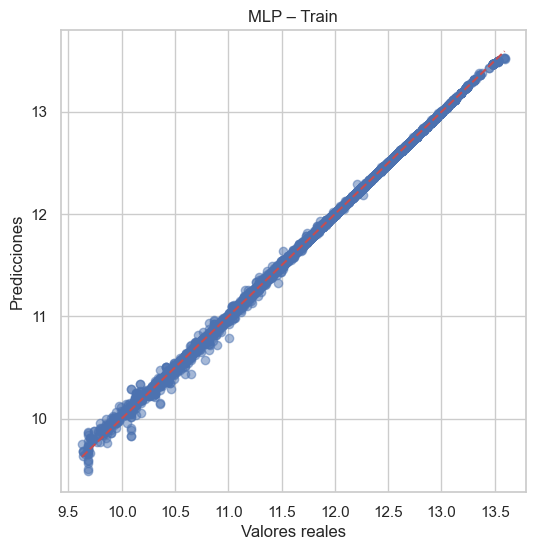

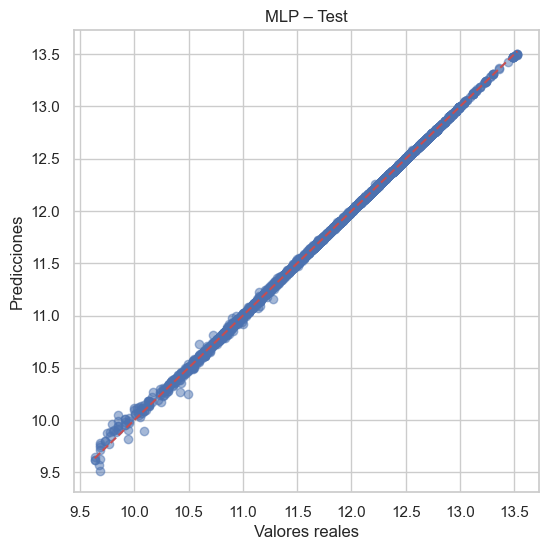


Resultados de Métricas:
              Train_RMSE  Train_MAE  Test_RMSE  Test_MAE
Modelo                                                  
Ridge           0.141021   0.092551   0.142868  0.093703
Lasso           0.166155   0.107303   0.168214  0.108237
KNN             0.048161   0.013596   0.073948  0.022855
DecisionTree    0.311508   0.234666   0.311336  0.235288
SVR             0.063990   0.056993   0.065309  0.057945
XGB             0.007614   0.002751   0.010102  0.002975
MLP             0.007527   0.002959   0.007668  0.002975

Resultados del Test BDS:
                          BDS_Stat              p_value  \
Ridge         -0.10115855494665842   0.9194245962556316   
Lasso          0.23104875586978652   0.8172769248763921   
KNN              1.503958333708344   0.1325920954596185   
DecisionTree   0.25660947286034963   0.7974802615417469   
SVR            -1.1604170708863144   0.2458790397788978   
XGB             1.2679485187905826  0.20481633576720304   
MLP             1.88112

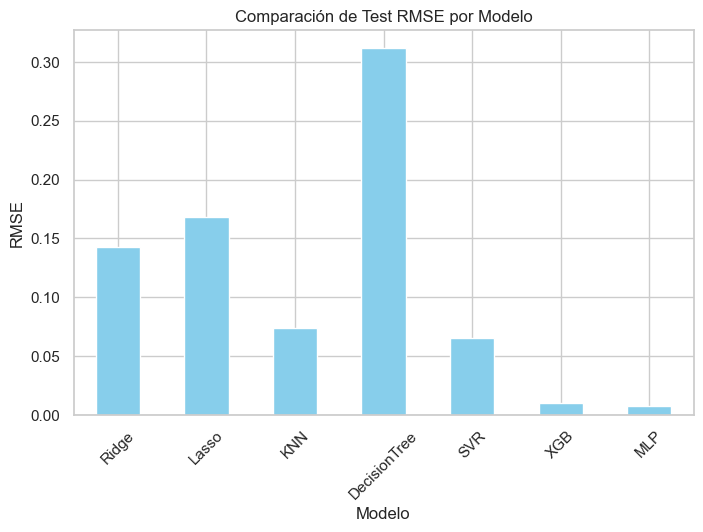

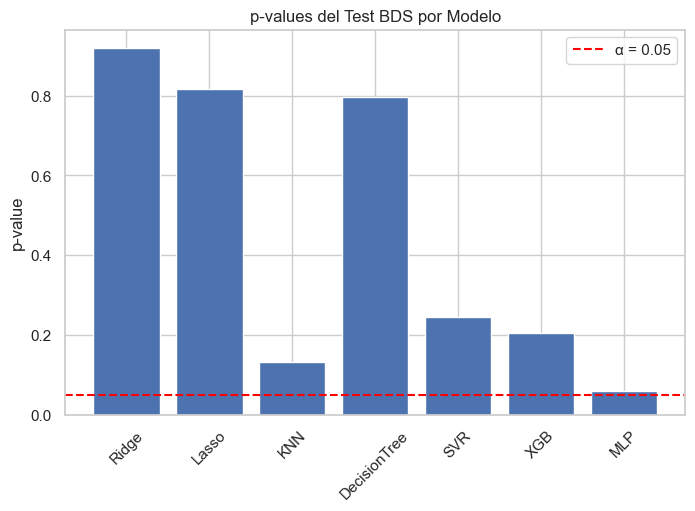

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import bds

# 1. Funciones auxiliares
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Calcula métricas de desempeño para un modelo de regresión.
    """
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas en Train
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Métricas en Test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    return {
        "Modelo": name,
        "Train_RMSE": train_rmse,
        "Train_MAE": train_mae,
        "Test_RMSE": test_rmse,
        "Test_MAE": test_mae,
    }

def bds_test(y_true, y_pred, max_dim=2, epsilon=None, distance=1.5):
    """
    Aplica el test BDS (Brock-Dechert-Scheinkman) a los residuos del modelo.
    """
    residuals = np.array(y_true) - np.array(y_pred)
    residuals = residuals[~np.isnan(residuals)]  # elimina NaNs
    
    stat, pvalue = bds(residuals, max_dim=max_dim, epsilon=epsilon, distance=distance)
    return stat, pvalue

def plot_predictions(y_true, y_pred, title):
    """
    Gráfico de comparación entre valores reales y predichos.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--')
    plt.title(title)
    plt.xlabel("Valores reales")
    plt.ylabel("Predicciones")
    plt.show()

# 2. Diccionarios para resultados
results_list = []
bds_results = {}

# 3. Loop sobre modelos
for name, search in [
    ("Ridge", ridge_search),
    ("Lasso", lasso_search),
    ("KNN", knn_search),
    ("DecisionTree", dtree_search),
    ("SVR", svr_search),
    ("XGB", xgb_search),
    ("MLP", mlp_search)
]:
    best_model = search.best_estimator_
    
    # Métricas del modelo
    metrics = evaluate_model(name, best_model, X_train_reg, X_test_reg,
                              y_train_reg, y_test_reg)
    results_list.append(metrics)
    
    # Test BDS en TEST
    y_test_pred = best_model.predict(X_test_reg)
    stat, pvalue = bds_test(y_test_reg, y_test_pred)
    bds_results[name] = (stat, pvalue)
    
    # Gráficos de predicción
    plot_predictions(y_train_reg, best_model.predict(X_train_reg), f"{name} – Train")
    plot_predictions(y_test_reg, y_test_pred, f"{name} – Test")

# 4. DataFrames con resultados
# Métricas
metrics_df = pd.DataFrame(results_list).set_index("Modelo")

# BDS Test
bds_df = pd.DataFrame(bds_results, index=["BDS_Stat", "p_value"]).T
bds_df["Interpretación"] = np.where(
    bds_df["p_value"] > 0.05,
    "Residuos independientes (i.i.d.)",
    "Dependencia no lineal"
)

print("\nResultados de Métricas:")
print(metrics_df)

print("\nResultados del Test BDS:")
print(bds_df)

# 5. Gráficos comparativos

# RMSE
plt.figure(figsize=(8, 5))
metrics_df["Test_RMSE"].plot(kind="bar", color="skyblue")
plt.title("Comparación de Test RMSE por Modelo")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()


# BDS p-values
plt.figure(figsize=(8, 5))
plt.bar(bds_df.index, bds_df["p_value"])
plt.axhline(y=0.05, color="red", linestyle="--", label="α = 0.05")
plt.title("p-values del Test BDS por Modelo")
plt.ylabel("p-value")
plt.xticks(rotation=45)
plt.legend()
plt.show()


## 9. DataFrame de resultados y gráfico comparativo - Salario en USD

1. Construimos un DataFrame con todas las métricas por modelo y dataset.
2. Mostramos resultados del BDS Test.

Con esto tenemos un resumen visual y tabular para comparar rendimientos.


In [46]:
import matplotlib.pyplot as plt
from numpy import expm1
from statsmodels.tsa.stattools import bds
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ----------------------------
# Función de evaluación
# ----------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test, log_target=True):
    """
    Calcula métricas de desempeño para un modelo de regresión.
    Si log_target=True, invierte la transformación logarítmica con expm1.
    """
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    if log_target:
        y_train_pred = expm1(y_train_pred)
        y_test_pred = expm1(y_test_pred)
        y_train = expm1(y_train)
        y_test = expm1(y_test)

    # Métricas en Train
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

    # Métricas en Test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    return {
        "Modelo": name,
        "Train_RMSE": train_rmse,
        "Train_MAE": train_mae,
        "Train_MSE": train_mse,
        "Train_MAPE": train_mape,
        "Test_RMSE": test_rmse,
        "Test_MAE": test_mae,
        "Test_MSE": test_mse,
        "Test_MAPE": test_mape
    }

# Test BDS
def bds_test(y_true, y_pred, log_target=True, max_dim=2, epsilon=None, distance=1.5):
    """
    Aplica el test BDS a los residuos del modelo.
    """
    if log_target:
        y_true = expm1(y_true)
        y_pred = expm1(y_pred)

    residuals = np.array(y_true) - np.array(y_pred)
    residuals = residuals[~np.isnan(residuals)]
    
    stat, pvalue = bds(residuals, max_dim=max_dim, epsilon=epsilon, distance=distance)
    return stat, pvalue

results_list = []
bds_results = {}

for name, search in [
    ("Ridge", ridge_search),
    ("Lasso", lasso_search),
    ("KNN", knn_search),
    ("DecisionTree", dtree_search),
    ("SVR", svr_search),
    ("XGB", xgb_search),
    ("MLP", mlp_search)
]:
    best_model = search.best_estimator_

    # Evaluación
    metrics = evaluate_model(name, best_model, X_train_reg, X_test_reg, y_train_reg, y_test_reg)
    results_list.append(metrics)

    # BDS test
    y_test_pred = best_model.predict(X_test_reg)
    stat, pvalue = bds_test(y_test_reg, y_test_pred)
    bds_results[name] = (stat, pvalue)


# DataFrame de resultados

results_df = pd.DataFrame(results_list).set_index("Modelo")

# Estilo de tabla
styled_results = (
    results_df.style
    .background_gradient(cmap="Reds", subset=["Train_RMSE", "Train_MAE", "Train_MSE", "Train_MAPE",
                                              "Test_RMSE", "Test_MAE", "Test_MSE", "Test_MAPE"])
    .format({
        "Train_RMSE": "{:,.0f}",
        "Train_MAE": "{:,.0f}",
        "Train_MSE": "{:,.0f}",
        "Train_MAPE": "{:.2f}%",
        "Test_RMSE": "{:,.0f}",
        "Test_MAE": "{:,.0f}",
        "Test_MSE": "{:,.0f}",
        "Test_MAPE": "{:.2f}%"
    })
    .set_table_styles(
        [
            {"selector": "th", "props": [("background-color", "#b22222"), ("color", "white"), ("font-weight", "bold")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16px")]}
        ]
    )
    .set_caption("Comparación de Modelos – Train vs Test (MSE, RMSE, MAE, MAPE en escala original USD)")
)

display(styled_results)

# Resultados del Test BDS
bds_df = pd.DataFrame(bds_results, index=["BDS_Stat", "p_value"]).T
bds_df["Interpretación"] = np.where(
    bds_df["p_value"] > 0.05,
    "Residuos independientes (i.i.d.)",
    "Dependencia no lineal"
)
print("\nResultados del Test BDS:")
print(bds_df)

,Train_RMSE,Train_MAE,Train_MSE,Train_MAPE,Test_RMSE,Test_MAE,Test_MSE,Test_MAPE
Modelo,,,,,,,,
Ridge,"89,141","17,063","7,946,063,067",9.91%,"89,435","16,958","7,998,632,355",10.04%
Lasso,"113,582","20,375","12,900,967,121",11.98%,"111,077","20,075","12,338,054,113",12.12%
KNN,"5,576","1,612","31,086,354",1.38%,"8,698","2,720","75,650,697",2.35%
DecisionTree,"53,540","35,456","2,866,578,606",25.02%,"52,958","35,319","2,804,514,269",25.11%
SVR,"10,861","8,917","117,953,790",5.79%,"10,908","8,987","118,987,553",5.89%
XGB,"2,501",446,"6,254,799",0.28%,"2,557",447,"6,536,201",0.30%
MLP,877,356,"769,119",0.30%,765,348,"584,483",0.30%



Resultados del Test BDS:
                          BDS_Stat              p_value  \
Ridge          0.39049622066326917   0.6961696494130757   
Lasso           0.4356148820585588   0.6631161714171481   
KNN              1.630669270536125  0.10296012401602096   
DecisionTree  -0.18832926825651072   0.8506185430863035   
SVR           -0.38461763210239674   0.7005207287186843   
XGB             0.1449928439176952   0.8847165218115558   
MLP            0.29506157773732233   0.7679468402170485   

                                Interpretación  
Ridge         Residuos independientes (i.i.d.)  
Lasso         Residuos independientes (i.i.d.)  
KNN           Residuos independientes (i.i.d.)  
DecisionTree  Residuos independientes (i.i.d.)  
SVR           Residuos independientes (i.i.d.)  
XGB           Residuos independientes (i.i.d.)  
MLP           Residuos independientes (i.i.d.)  


## **Conclusión**

### **Resultados del Test BDS**

Todos los modelos (Ridge, Lasso, KNN, Decision Tree, SVR, XGB y MLP) muestran **p-values > 0.05**, lo que significa que **no rechazamos la hipótesis nula de independencia.**

Los **residuos parecen ser i.i.d. (independientes e idénticamente distribuidos)**, lo cual es deseable en un modelo de regresión, porque indica que no hay evidencia de **dependencia no lineal** no explicada por los modelos.

El **KNN** fue el que más cerca estuvo del umbral (p = 0.103), pero aun así se mantiene dentro del rango aceptable.

Modelos como **DecisionTree y XGB** tienen p-values muy altos (>0.80), lo que refuerza la idea de que sus residuos son bastante aleatorios.

**En conclusión:** ningún modelo presenta problemas serios de dependencia en los residuos, lo cual respalda la validez de las métricas que ya calculaste (RMSE, MAE, MSE, MAPE).

### Conclusión general:

El análisis comparativo de modelos de regresión, evaluados mediante métricas en la escala original de USD (MAE, MSE, RMSE y MAPE), evidencia diferencias significativas en la capacidad predictiva de los algoritmos considerados.

Los modelos **XGBoost (XGB) y Multilayer Perceptron (MLP)** presentan un desempeño claramente superior, con errores absolutos y relativos mínimos (MAPE < 1%), además de una adecuada capacidad de generalización entre los conjuntos de entrenamiento y prueba. Esto los posiciona como las alternativas más robustas y confiables para la predicción de salarios en este contexto.

Los modelos **KNN** y **SVR** alcanzan resultados aceptables, con errores moderados (MAPE entre 2% y 6%), aunque no logran la precisión observada en XGB y MLP.

En contraste, los enfoques lineales **(Ridge y Lasso)** muestran un desempeño considerablemente inferior, con errores altos (MAPE ~10–12%) que reflejan su limitación para capturar relaciones no lineales presentes en los datos. Finalmente, **Decision Tree** se caracteriza por una gran inestabilidad y altos errores relativos (MAPE ~25%), lo que lo hace inadecuado como solución final.

En conjunto, los resultados indican que **la incorporación de modelos no lineales y de mayor complejidad** (en particular, XGB y MLP) constituye la mejor estrategia para abordar este problema de predicción de salarios, maximizando precisión y consistencia en las estimaciones.

### 📌 Recomendaciones  

Con base en el análisis comparativo de modelos (MAE, MSE, RMSE y MAPE en escala USD), se sugieren las siguientes recomendaciones para la predicción de salarios:  

- ✅ **Priorizar modelos de mejor desempeño:**  
  Implementar **XGBoost (XGB)** o **Multilayer Perceptron (MLP)** como modelos principales, ya que alcanzan los **menores errores relativos (MAPE < 1%)** y muestran gran capacidad de generalización.  

- ⚖️ **Usar modelos intermedios como referencia:**  
  **KNN** y **SVR** pueden considerarse como alternativas de contraste, con resultados moderados (MAPE entre 2% y 6%).  

- ❌ **Evitar modelos lineales en producción:**  
  **Ridge** y **Lasso** presentan errores elevados (~10–12%), lo que indica limitaciones en la captura de relaciones complejas.  

- ⚠️ **Descartar árboles de decisión simples:**  
  El **Decision Tree** mostró un error sustancial (MAPE ~25%) y alta inestabilidad, por lo que no se recomienda su uso en este contexto.  

📊 **Recomendación global:**  
Adoptar un enfoque basado en **modelos no lineales y de mayor complejidad (XGB y MLP)** garantiza mayor **precisión y consistencia** en las estimaciones salariales.  